In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler, WeightedRandomSampler
import torchvision.models as models
import datetime
import torch.nn.init as init
import torch

W0225 09:12:08.676432 18552 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W0225 09:12:08.697432 18552 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 512
np.random.seed(1)
torch.manual_seed(1)
torch.set_num_threads(4)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning

alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
#bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker 
#chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
#dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#a6= sy.VirtualWorker(hook, id="a6")  # <-- NEW: define remote worker
#a7= sy.VirtualWorker(hook, id="a7")  # <-- NEW: define remote worker
#a8= sy.VirtualWorker(hook, id="a8")  # <-- NEW: define remote worker
#a9= sy.VirtualWorker(hook, id="a9")  # <-- NEW: define remote worker
#a10= sy.VirtualWorker(hook, id="a10")  # <-- NEW: define remote worker
#a11= sy.VirtualWorker(hook, id="a11")  # <-- NEW: define remote worker
#a12= sy.VirtualWorker(hook, id="a12")  # <-- NEW: define remote worker
#a13= sy.VirtualWorker(hook, id="a13")  # <-- NEW: define remote worker
#a14= sy.VirtualWorker(hook, id="a14")  # <-- NEW: define remote worker
#a15= sy.VirtualWorker(hook, id="a15")  # <-- NEW: define remote worker
#a16= sy.VirtualWorker(hook, id="a16")  # <-- NEW: define remote worker
#a17= sy.VirtualWorker(hook, id="a17")  # <-- NEW: define remote worker
#a18= sy.VirtualWorker(hook, id="a18")  # <-- NEW: define remote worker
#a19= sy.VirtualWorker(hook, id="a19")  # <-- NEW: define remote worker


#fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 

compute_nodes = [alice]
#frauds = [fraudulin]

# Helper function for dataset loader generation

In [4]:
#def generateLoadersPerClass(dataset):
#    #loaders per class
#    loaders_per_class = []
#    for class_name in dataset.classes:
#        # get the indices in the dataset that are relative to that class
#        idx = [
#            pos for pos, item in enumerate(dataset.samples)
#            if item[1] == dataset.class_to_idx[class_name]]
#        # construct the corresponding dataloader thanks to a SubsetRandomSampler
#        loaders_per_class += [torch.utils.data.DataLoader(
#            dataset, 
#            batch_size=batch_size,
#            sampler=SubsetRandomSampler(idx),
#            **kwargs)]
#    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])


#benign data
trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\GTSRB\\Training',
                             transform=data_transform)
original_loader = torch.utils.data.DataLoader(trafficsign, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#original_loaders = generateLoadersPerClass(trafficsign)

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\GTSRB\\Test',
                             transform=data_transform)

test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)



# Load backdoor dataset

In [6]:
#malicious data
#backdoored = datasets.ImageFolder(root = 
#                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare',
#                             transform=data_transform)
#backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
#backdoored_loader = torch.utils.data.DataLoader(backdoored, 
#                batch_size=batch_size,
#                shuffle=True,
#                **kwargs)
##backdoored_loaders = generateLoadersPerClass(backdoored)
#
##malicious test data
#backdoored_test = datasets.ImageFolder(root = 
#                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare_test',
#                             transform=data_transform)
#backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples] #set each image of backdoors to 001
#
#dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

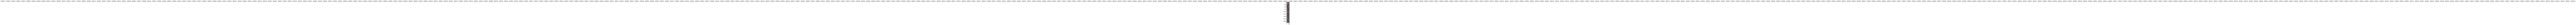

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(original_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.bn0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool_0 = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool_1 = nn.MaxPool2d(2, stride=2)
        self.dropout0 = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout1 = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout2 = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.pool_0(F.relu(self.bn1(self.conv1(x))))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool_1(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout0(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf

# Send dataset to clients

In [9]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#EACH CLIENT KNOWS EACH CLASS
#normal clients
for batch_idx, (data,target) in enumerate(original_loader):
            data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            train_distributed_dataset.append((data_append, target_append))

#backdoored clients
#for batch_idx, (data,target) in enumerate(backdoored_loader):
#            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
#            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
#            train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
#shuffle(train_distributed_dataset_backdoor)

#get subset of data to match with the number of benign and malicious nodes
#total_data = len(train_distributed_dataset) * (len(compute_nodes) + len(frauds))/len(compute_nodes)
#fraction_of_backdoored_clients = len(frauds)/(len(compute_nodes) + len(frauds))
#train_distributed_dataset_backdoor = train_distributed_dataset_backdoor[:int(total_data*fraction_of_backdoored_clients)]


# Training Function

In [10]:
def train(epoch, normal_or_backdoored_dataset):
    model.train()
    totalloss = 0
    number_iterations = 0
    
    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
                100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))
    return float(totalloss/number_iterations)

# Test Function

In [11]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    #print(confusion_matrix)
    per_class_accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)
    print(per_class_accuracy) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset)), per_class_accuracy

# Run everyting

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_gtsrb_"+dateString+".txt"),"w+")
f= open(("exp_gtsrb_perClassAccuracy_"+dateString+".txt"),"w+")

#EXP-setup
csv_header =  "#dataset: " + "gtsrb" + "\n"
csv_header += "#way backdoor looks like: " + "None" + "\n"
csv_header += "#merge strategy: " + "sequential" + "\n"
csv_header += "#number of benign sources: " + str(len(compute_nodes)) + "\n"
csv_header += "#number of malicious sources: " + str(0) + "\n" #str(len(frauds))
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + "100" + "\n" #str(100)
csv_header += "#order of time backdoors being inserted: " + "None" + "\n" #backdoors first
csv_header += "#attack model: " + "basic" + "\n" #basic
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 101):
    csv_normal = "normal;" + str(epoch) + ";" + str(0.0001) + ";"
    #csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train backdoor
    #avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    #csv_backdoor += str(avg_training_backdoor_loss) + ";"
    #timestamp_backdoor = datetime.datetime.now().strftime("%H%M%S")
    
    #train normal
    avg_training_loss = train(epoch, train_distributed_dataset)
    csv_normal += str(avg_training_loss) + ";"
    timestamp_normal = datetime.datetime.now().strftime("%H%M%S")
    
    #save after each 10 iterations
    if epoch % 10 == 0:
        torch.save(model.state_dict(), ("exp_gtsrb_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    #test_loss, acc, per_class_accuracy_backdoor= test(model, device, dataset_loader_backdoored_test, len(backdoored_test))
    #csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc, per_class_accuracy = test(model, device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"

    #scheduler.step(test_loss)

    csv_normal += timestamp_normal + "\n"
    #csv_backdoor += timestamp_backdoor + "\n"
    
    #Write to file
    f= open(("exp_gtsrb_"+dateString+".txt"),"a+")
    f2= open(("exp_gtsrb_perClassAccuracy_"+dateString+".txt"),"a+")

    #f.write(csv_backdoor)
    
    f.write(csv_normal)
    f2.write(str(per_class_accuracy) + "\n")
    
    f.close()
    f2.close()

#dataset: gtsrb
#way backdoor looks like: None
#merge strategy: sequential
#number of benign sources: 1
#number of malicious sources: 0
#batch size: 512
#distribution of data: equally distributed subset
#percentage of poisoned data in backdoored nodes: 100
#order of time backdoors being inserted: None
#attack model: basic
#starttime: 091236
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Train Epoch: 1 [0/39424 (0%)]	Loss: 3.759758
Train Epoch: 1 [512/39424 (1%)]	Loss: 3.760672
Train Epoch: 1 [1024/39424 (3%)]	Loss: 3.759073
Train Epoch: 1 [1536/39424 (4%)]	Loss: 3.759168
Train Epoch: 1 [2048/39424 (5%)]	Loss: 3.759057
Train Epoch: 1 [2560/39424 (6%)]	Loss: 3.758594
Train Epoch: 1 [3072/39424 (8%)]	Loss: 3.757816
Train Epoch: 1 [3584/39424 (9%)]	Loss: 3.755872
Train Epoch: 1 [4096/39424 (10%)]	Loss: 3.757708
Train Epoch: 1 [4608/39424 (12%)]	Loss: 3.757655
Train Epoch: 1 [5120/39424 (13%)]	Loss: 3.755727
Train Epoch: 1 [5632/39424 (14%)]	L

Train Epoch: 2 [37376/39424 (95%)]	Loss: 3.679129
Train Epoch: 2 [37888/39424 (96%)]	Loss: 3.670302
Train Epoch: 2 [38400/39424 (97%)]	Loss: 3.673563
Train Epoch: 2 [38912/39424 (99%)]	Loss: 3.664774
Average training loss: 3.708035945892334

Test set: Average loss: 3.6721, Accuracy: 750/12630 (6%)

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 3 [0/39424 (0%)]	Loss: 3.667184
Train Epoch: 3 [512/39424 (1%)]	Loss: 3.683914
Train Epoch: 3 [1024/39424 (3%)]	Loss: 3.663284
Train Epoch: 3 [1536/39424 (4%)]	Loss: 3.670110
Train Epoch: 3 [2048/39424 (5%)]	Loss: 3.676602
Train Epoch: 3 [2560/39424 (6%)]	Loss: 3.669405
Train Epoch: 3 [3072/39424 (8%)]	Loss: 3.673069
Train Epoch: 3 [3584/39424 (9%)]	Loss: 3.658497
Train Epoch: 3 [4096/39424 (10%)]	Loss: 3.669852
Train Epoch: 3 [4608/39424 (12%)]	Loss: 3.667380
Train Epoch: 3 [5120/3942

Train Epoch: 4 [34816/39424 (88%)]	Loss: 3.510556
Train Epoch: 4 [35328/39424 (90%)]	Loss: 3.485016
Train Epoch: 4 [35840/39424 (91%)]	Loss: 3.492318
Train Epoch: 4 [36352/39424 (92%)]	Loss: 3.506015
Train Epoch: 4 [36864/39424 (94%)]	Loss: 3.468002
Train Epoch: 4 [37376/39424 (95%)]	Loss: 3.467960
Train Epoch: 4 [37888/39424 (96%)]	Loss: 3.396241
Train Epoch: 4 [38400/39424 (97%)]	Loss: 3.444458
Train Epoch: 4 [38912/39424 (99%)]	Loss: 3.409635
Average training loss: 3.483525276184082

Test set: Average loss: 3.4579, Accuracy: 1327/12630 (11%)

tensor([0.0000, 0.0847, 0.3187, 0.0000, 0.0818, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.9076, 0.0000, 0.0029, 0.4403, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0797, 0.0000, 0.0000, 0.0000, 0.0000])
Train Epoch: 5 [0/39424 (0%)]	Loss: 3.444062
Train Epoch: 5 [51

Train Epoch: 6 [30208/39424 (77%)]	Loss: 3.386608
Train Epoch: 6 [30720/39424 (78%)]	Loss: 3.358160
Train Epoch: 6 [31232/39424 (79%)]	Loss: 3.391649
Train Epoch: 6 [31744/39424 (81%)]	Loss: 3.403781
Train Epoch: 6 [32256/39424 (82%)]	Loss: 3.429406
Train Epoch: 6 [32768/39424 (83%)]	Loss: 3.426468
Train Epoch: 6 [33280/39424 (84%)]	Loss: 3.414654
Train Epoch: 6 [33792/39424 (86%)]	Loss: 3.404582
Train Epoch: 6 [34304/39424 (87%)]	Loss: 3.364617
Train Epoch: 6 [34816/39424 (88%)]	Loss: 3.416316
Train Epoch: 6 [35328/39424 (90%)]	Loss: 3.420089
Train Epoch: 6 [35840/39424 (91%)]	Loss: 3.430772
Train Epoch: 6 [36352/39424 (92%)]	Loss: 3.423586
Train Epoch: 6 [36864/39424 (94%)]	Loss: 3.367539
Train Epoch: 6 [37376/39424 (95%)]	Loss: 3.391647
Train Epoch: 6 [37888/39424 (96%)]	Loss: 3.326839
Train Epoch: 6 [38400/39424 (97%)]	Loss: 3.413099
Train Epoch: 6 [38912/39424 (99%)]	Loss: 3.318521
Average training loss: 3.409411907196045

Test set: Average loss: 3.4010, Accuracy: 1456/12630 (12%)

Train Epoch: 8 [25600/39424 (65%)]	Loss: 3.260689
Train Epoch: 8 [26112/39424 (66%)]	Loss: 3.261362
Train Epoch: 8 [26624/39424 (68%)]	Loss: 3.290258
Train Epoch: 8 [27136/39424 (69%)]	Loss: 3.296419
Train Epoch: 8 [27648/39424 (70%)]	Loss: 3.362399
Train Epoch: 8 [28160/39424 (71%)]	Loss: 3.381503
Train Epoch: 8 [28672/39424 (73%)]	Loss: 3.284261
Train Epoch: 8 [29184/39424 (74%)]	Loss: 3.240697
Train Epoch: 8 [29696/39424 (75%)]	Loss: 3.318760
Train Epoch: 8 [30208/39424 (77%)]	Loss: 3.299918
Train Epoch: 8 [30720/39424 (78%)]	Loss: 3.268023
Train Epoch: 8 [31232/39424 (79%)]	Loss: 3.292838
Train Epoch: 8 [31744/39424 (81%)]	Loss: 3.296761
Train Epoch: 8 [32256/39424 (82%)]	Loss: 3.315200
Train Epoch: 8 [32768/39424 (83%)]	Loss: 3.311030
Train Epoch: 8 [33280/39424 (84%)]	Loss: 3.304085
Train Epoch: 8 [33792/39424 (86%)]	Loss: 3.272909
Train Epoch: 8 [34304/39424 (87%)]	Loss: 3.276995
Train Epoch: 8 [34816/39424 (88%)]	Loss: 3.320838
Train Epoch: 8 [35328/39424 (90%)]	Loss: 3.358033


Train Epoch: 10 [20480/39424 (52%)]	Loss: 2.830805
Train Epoch: 10 [20992/39424 (53%)]	Loss: 2.910907
Train Epoch: 10 [21504/39424 (55%)]	Loss: 2.879278
Train Epoch: 10 [22016/39424 (56%)]	Loss: 2.818276
Train Epoch: 10 [22528/39424 (57%)]	Loss: 2.828500
Train Epoch: 10 [23040/39424 (58%)]	Loss: 2.910170
Train Epoch: 10 [23552/39424 (60%)]	Loss: 2.854529
Train Epoch: 10 [24064/39424 (61%)]	Loss: 2.892311
Train Epoch: 10 [24576/39424 (62%)]	Loss: 2.790561
Train Epoch: 10 [25088/39424 (64%)]	Loss: 2.763262
Train Epoch: 10 [25600/39424 (65%)]	Loss: 2.702320
Train Epoch: 10 [26112/39424 (66%)]	Loss: 2.781805
Train Epoch: 10 [26624/39424 (68%)]	Loss: 2.783169
Train Epoch: 10 [27136/39424 (69%)]	Loss: 2.780488
Train Epoch: 10 [27648/39424 (70%)]	Loss: 2.785052
Train Epoch: 10 [28160/39424 (71%)]	Loss: 2.821513
Train Epoch: 10 [28672/39424 (73%)]	Loss: 2.719932
Train Epoch: 10 [29184/39424 (74%)]	Loss: 2.666063
Train Epoch: 10 [29696/39424 (75%)]	Loss: 2.806764
Train Epoch: 10 [30208/39424 (7

Train Epoch: 12 [14336/39424 (36%)]	Loss: 1.645775
Train Epoch: 12 [14848/39424 (38%)]	Loss: 1.769201
Train Epoch: 12 [15360/39424 (39%)]	Loss: 1.648034
Train Epoch: 12 [15872/39424 (40%)]	Loss: 1.762603
Train Epoch: 12 [16384/39424 (42%)]	Loss: 1.721625
Train Epoch: 12 [16896/39424 (43%)]	Loss: 1.568436
Train Epoch: 12 [17408/39424 (44%)]	Loss: 1.635926
Train Epoch: 12 [17920/39424 (45%)]	Loss: 1.692997
Train Epoch: 12 [18432/39424 (47%)]	Loss: 1.625092
Train Epoch: 12 [18944/39424 (48%)]	Loss: 1.560308
Train Epoch: 12 [19456/39424 (49%)]	Loss: 1.615289
Train Epoch: 12 [19968/39424 (51%)]	Loss: 1.711640
Train Epoch: 12 [20480/39424 (52%)]	Loss: 1.532607
Train Epoch: 12 [20992/39424 (53%)]	Loss: 1.596539
Train Epoch: 12 [21504/39424 (55%)]	Loss: 1.559900
Train Epoch: 12 [22016/39424 (56%)]	Loss: 1.572027
Train Epoch: 12 [22528/39424 (57%)]	Loss: 1.540291
Train Epoch: 12 [23040/39424 (58%)]	Loss: 1.616971
Train Epoch: 12 [23552/39424 (60%)]	Loss: 1.542096
Train Epoch: 12 [24064/39424 (6

Train Epoch: 14 [8192/39424 (21%)]	Loss: 1.121260
Train Epoch: 14 [8704/39424 (22%)]	Loss: 1.063314
Train Epoch: 14 [9216/39424 (23%)]	Loss: 0.987733
Train Epoch: 14 [9728/39424 (25%)]	Loss: 1.084467
Train Epoch: 14 [10240/39424 (26%)]	Loss: 0.936465
Train Epoch: 14 [10752/39424 (27%)]	Loss: 1.039262
Train Epoch: 14 [11264/39424 (29%)]	Loss: 0.976049
Train Epoch: 14 [11776/39424 (30%)]	Loss: 1.009707
Train Epoch: 14 [12288/39424 (31%)]	Loss: 1.070813
Train Epoch: 14 [12800/39424 (32%)]	Loss: 0.978199
Train Epoch: 14 [13312/39424 (34%)]	Loss: 0.964013
Train Epoch: 14 [13824/39424 (35%)]	Loss: 1.037901
Train Epoch: 14 [14336/39424 (36%)]	Loss: 0.956538
Train Epoch: 14 [14848/39424 (38%)]	Loss: 0.991572
Train Epoch: 14 [15360/39424 (39%)]	Loss: 0.958986
Train Epoch: 14 [15872/39424 (40%)]	Loss: 0.965914
Train Epoch: 14 [16384/39424 (42%)]	Loss: 1.030313
Train Epoch: 14 [16896/39424 (43%)]	Loss: 0.924346
Train Epoch: 14 [17408/39424 (44%)]	Loss: 0.925881
Train Epoch: 14 [17920/39424 (45%)]

Train Epoch: 16 [2048/39424 (5%)]	Loss: 0.713969
Train Epoch: 16 [2560/39424 (6%)]	Loss: 0.742496
Train Epoch: 16 [3072/39424 (8%)]	Loss: 0.697925
Train Epoch: 16 [3584/39424 (9%)]	Loss: 0.715264
Train Epoch: 16 [4096/39424 (10%)]	Loss: 0.696472
Train Epoch: 16 [4608/39424 (12%)]	Loss: 0.746926
Train Epoch: 16 [5120/39424 (13%)]	Loss: 0.692531
Train Epoch: 16 [5632/39424 (14%)]	Loss: 0.685871
Train Epoch: 16 [6144/39424 (16%)]	Loss: 0.656598
Train Epoch: 16 [6656/39424 (17%)]	Loss: 0.706916
Train Epoch: 16 [7168/39424 (18%)]	Loss: 0.774593
Train Epoch: 16 [7680/39424 (19%)]	Loss: 0.676075
Train Epoch: 16 [8192/39424 (21%)]	Loss: 0.716919
Train Epoch: 16 [8704/39424 (22%)]	Loss: 0.716603
Train Epoch: 16 [9216/39424 (23%)]	Loss: 0.640375
Train Epoch: 16 [9728/39424 (25%)]	Loss: 0.745357
Train Epoch: 16 [10240/39424 (26%)]	Loss: 0.674758
Train Epoch: 16 [10752/39424 (27%)]	Loss: 0.709964
Train Epoch: 16 [11264/39424 (29%)]	Loss: 0.679205
Train Epoch: 16 [11776/39424 (30%)]	Loss: 0.712284


        0.7667, 0.8000, 0.9348, 0.7667, 0.6333, 0.7833, 0.6667])
Train Epoch: 18 [0/39424 (0%)]	Loss: 0.560896
Train Epoch: 18 [512/39424 (1%)]	Loss: 0.594453
Train Epoch: 18 [1024/39424 (3%)]	Loss: 0.413085
Train Epoch: 18 [1536/39424 (4%)]	Loss: 0.539960
Train Epoch: 18 [2048/39424 (5%)]	Loss: 0.543094
Train Epoch: 18 [2560/39424 (6%)]	Loss: 0.581521
Train Epoch: 18 [3072/39424 (8%)]	Loss: 0.523704
Train Epoch: 18 [3584/39424 (9%)]	Loss: 0.593334
Train Epoch: 18 [4096/39424 (10%)]	Loss: 0.567298
Train Epoch: 18 [4608/39424 (12%)]	Loss: 0.524767
Train Epoch: 18 [5120/39424 (13%)]	Loss: 0.526177
Train Epoch: 18 [5632/39424 (14%)]	Loss: 0.504883
Train Epoch: 18 [6144/39424 (16%)]	Loss: 0.477917
Train Epoch: 18 [6656/39424 (17%)]	Loss: 0.571630
Train Epoch: 18 [7168/39424 (18%)]	Loss: 0.615232
Train Epoch: 18 [7680/39424 (19%)]	Loss: 0.472805
Train Epoch: 18 [8192/39424 (21%)]	Loss: 0.560660
Train Epoch: 18 [8704/39424 (22%)]	Loss: 0.530125
Train Epoch: 18 [9216/39424 (23%)]	Loss: 0.4491

Train Epoch: 19 [37888/39424 (96%)]	Loss: 0.461707
Train Epoch: 19 [38400/39424 (97%)]	Loss: 0.508643
Train Epoch: 19 [38912/39424 (99%)]	Loss: 0.342073
Average training loss: 0.4534708559513092

Test set: Average loss: 0.6026, Accuracy: 10726/12630 (85%)

tensor([0.1167, 0.8597, 0.8147, 0.8311, 0.8894, 0.8238, 0.6800, 0.6844, 0.8178,
        0.9375, 0.9455, 0.8548, 0.8957, 0.9611, 0.9926, 0.8714, 0.9800, 0.9472,
        0.6590, 0.4333, 0.9000, 0.3111, 0.8917, 0.6133, 0.4222, 0.8562, 0.6444,
        0.4333, 0.8067, 0.7778, 0.7200, 0.9333, 0.9000, 0.9714, 0.9750, 0.9590,
        0.8250, 0.8667, 0.9420, 0.9222, 0.8111, 0.7833, 0.7000])
Train Epoch: 20 [0/39424 (0%)]	Loss: 0.427746
Train Epoch: 20 [512/39424 (1%)]	Loss: 0.474203
Train Epoch: 20 [1024/39424 (3%)]	Loss: 0.337943
Train Epoch: 20 [1536/39424 (4%)]	Loss: 0.456300
Train Epoch: 20 [2048/39424 (5%)]	Loss: 0.405298
Train Epoch: 20 [2560/39424 (6%)]	Loss: 0.517333
Train Epoch: 20 [3072/39424 (8%)]	Loss: 0.452318
Train Epoch: 20 [35

Train Epoch: 21 [31744/39424 (81%)]	Loss: 0.357142
Train Epoch: 21 [32256/39424 (82%)]	Loss: 0.379917
Train Epoch: 21 [32768/39424 (83%)]	Loss: 0.292067
Train Epoch: 21 [33280/39424 (84%)]	Loss: 0.410873
Train Epoch: 21 [33792/39424 (86%)]	Loss: 0.337748
Train Epoch: 21 [34304/39424 (87%)]	Loss: 0.362551
Train Epoch: 21 [34816/39424 (88%)]	Loss: 0.330137
Train Epoch: 21 [35328/39424 (90%)]	Loss: 0.348813
Train Epoch: 21 [35840/39424 (91%)]	Loss: 0.342827
Train Epoch: 21 [36352/39424 (92%)]	Loss: 0.395014
Train Epoch: 21 [36864/39424 (94%)]	Loss: 0.381995
Train Epoch: 21 [37376/39424 (95%)]	Loss: 0.392984
Train Epoch: 21 [37888/39424 (96%)]	Loss: 0.366706
Train Epoch: 21 [38400/39424 (97%)]	Loss: 0.345838
Train Epoch: 21 [38912/39424 (99%)]	Loss: 0.289306
Average training loss: 0.37637683749198914

Test set: Average loss: 0.5624, Accuracy: 10893/12630 (86%)

tensor([0.1667, 0.8986, 0.8373, 0.8200, 0.9121, 0.8270, 0.7133, 0.7022, 0.8022,
        0.9438, 0.9409, 0.8738, 0.8971, 0.9542, 0.

Train Epoch: 23 [25600/39424 (65%)]	Loss: 0.314999
Train Epoch: 23 [26112/39424 (66%)]	Loss: 0.304722
Train Epoch: 23 [26624/39424 (68%)]	Loss: 0.322210
Train Epoch: 23 [27136/39424 (69%)]	Loss: 0.286022
Train Epoch: 23 [27648/39424 (70%)]	Loss: 0.275049
Train Epoch: 23 [28160/39424 (71%)]	Loss: 0.309056
Train Epoch: 23 [28672/39424 (73%)]	Loss: 0.313702
Train Epoch: 23 [29184/39424 (74%)]	Loss: 0.269833
Train Epoch: 23 [29696/39424 (75%)]	Loss: 0.336651
Train Epoch: 23 [30208/39424 (77%)]	Loss: 0.331859
Train Epoch: 23 [30720/39424 (78%)]	Loss: 0.342166
Train Epoch: 23 [31232/39424 (79%)]	Loss: 0.370769
Train Epoch: 23 [31744/39424 (81%)]	Loss: 0.292071
Train Epoch: 23 [32256/39424 (82%)]	Loss: 0.321654
Train Epoch: 23 [32768/39424 (83%)]	Loss: 0.216753
Train Epoch: 23 [33280/39424 (84%)]	Loss: 0.312217
Train Epoch: 23 [33792/39424 (86%)]	Loss: 0.284352
Train Epoch: 23 [34304/39424 (87%)]	Loss: 0.299469
Train Epoch: 23 [34816/39424 (88%)]	Loss: 0.233374
Train Epoch: 23 [35328/39424 (9

Train Epoch: 25 [19456/39424 (49%)]	Loss: 0.289751
Train Epoch: 25 [19968/39424 (51%)]	Loss: 0.266195
Train Epoch: 25 [20480/39424 (52%)]	Loss: 0.260560
Train Epoch: 25 [20992/39424 (53%)]	Loss: 0.360818
Train Epoch: 25 [21504/39424 (55%)]	Loss: 0.242046
Train Epoch: 25 [22016/39424 (56%)]	Loss: 0.306890
Train Epoch: 25 [22528/39424 (57%)]	Loss: 0.205182
Train Epoch: 25 [23040/39424 (58%)]	Loss: 0.244827
Train Epoch: 25 [23552/39424 (60%)]	Loss: 0.267111
Train Epoch: 25 [24064/39424 (61%)]	Loss: 0.324751
Train Epoch: 25 [24576/39424 (62%)]	Loss: 0.236167
Train Epoch: 25 [25088/39424 (64%)]	Loss: 0.219718
Train Epoch: 25 [25600/39424 (65%)]	Loss: 0.279403
Train Epoch: 25 [26112/39424 (66%)]	Loss: 0.252882
Train Epoch: 25 [26624/39424 (68%)]	Loss: 0.278114
Train Epoch: 25 [27136/39424 (69%)]	Loss: 0.243959
Train Epoch: 25 [27648/39424 (70%)]	Loss: 0.256170
Train Epoch: 25 [28160/39424 (71%)]	Loss: 0.248599
Train Epoch: 25 [28672/39424 (73%)]	Loss: 0.288229
Train Epoch: 25 [29184/39424 (7

Train Epoch: 27 [13312/39424 (34%)]	Loss: 0.254313
Train Epoch: 27 [13824/39424 (35%)]	Loss: 0.217005
Train Epoch: 27 [14336/39424 (36%)]	Loss: 0.232339
Train Epoch: 27 [14848/39424 (38%)]	Loss: 0.280603
Train Epoch: 27 [15360/39424 (39%)]	Loss: 0.246879
Train Epoch: 27 [15872/39424 (40%)]	Loss: 0.219358
Train Epoch: 27 [16384/39424 (42%)]	Loss: 0.286352
Train Epoch: 27 [16896/39424 (43%)]	Loss: 0.207978
Train Epoch: 27 [17408/39424 (44%)]	Loss: 0.278027
Train Epoch: 27 [17920/39424 (45%)]	Loss: 0.261394
Train Epoch: 27 [18432/39424 (47%)]	Loss: 0.213464
Train Epoch: 27 [18944/39424 (48%)]	Loss: 0.177371
Train Epoch: 27 [19456/39424 (49%)]	Loss: 0.265579
Train Epoch: 27 [19968/39424 (51%)]	Loss: 0.211620
Train Epoch: 27 [20480/39424 (52%)]	Loss: 0.232266
Train Epoch: 27 [20992/39424 (53%)]	Loss: 0.302521
Train Epoch: 27 [21504/39424 (55%)]	Loss: 0.195390
Train Epoch: 27 [22016/39424 (56%)]	Loss: 0.262031
Train Epoch: 27 [22528/39424 (57%)]	Loss: 0.166358
Train Epoch: 27 [23040/39424 (5

Train Epoch: 29 [7168/39424 (18%)]	Loss: 0.315574
Train Epoch: 29 [7680/39424 (19%)]	Loss: 0.219746
Train Epoch: 29 [8192/39424 (21%)]	Loss: 0.240946
Train Epoch: 29 [8704/39424 (22%)]	Loss: 0.227839
Train Epoch: 29 [9216/39424 (23%)]	Loss: 0.182712
Train Epoch: 29 [9728/39424 (25%)]	Loss: 0.294333
Train Epoch: 29 [10240/39424 (26%)]	Loss: 0.219015
Train Epoch: 29 [10752/39424 (27%)]	Loss: 0.244657
Train Epoch: 29 [11264/39424 (29%)]	Loss: 0.230149
Train Epoch: 29 [11776/39424 (30%)]	Loss: 0.195972
Train Epoch: 29 [12288/39424 (31%)]	Loss: 0.212070
Train Epoch: 29 [12800/39424 (32%)]	Loss: 0.218511
Train Epoch: 29 [13312/39424 (34%)]	Loss: 0.206191
Train Epoch: 29 [13824/39424 (35%)]	Loss: 0.172074
Train Epoch: 29 [14336/39424 (36%)]	Loss: 0.198905
Train Epoch: 29 [14848/39424 (38%)]	Loss: 0.236604
Train Epoch: 29 [15360/39424 (39%)]	Loss: 0.259322
Train Epoch: 29 [15872/39424 (40%)]	Loss: 0.200930
Train Epoch: 29 [16384/39424 (42%)]	Loss: 0.286163
Train Epoch: 29 [16896/39424 (43%)]	L

Train Epoch: 31 [1024/39424 (3%)]	Loss: 0.146247
Train Epoch: 31 [1536/39424 (4%)]	Loss: 0.224891
Train Epoch: 31 [2048/39424 (5%)]	Loss: 0.186623
Train Epoch: 31 [2560/39424 (6%)]	Loss: 0.215632
Train Epoch: 31 [3072/39424 (8%)]	Loss: 0.207755
Train Epoch: 31 [3584/39424 (9%)]	Loss: 0.200570
Train Epoch: 31 [4096/39424 (10%)]	Loss: 0.221303
Train Epoch: 31 [4608/39424 (12%)]	Loss: 0.175275
Train Epoch: 31 [5120/39424 (13%)]	Loss: 0.216770
Train Epoch: 31 [5632/39424 (14%)]	Loss: 0.148775
Train Epoch: 31 [6144/39424 (16%)]	Loss: 0.175429
Train Epoch: 31 [6656/39424 (17%)]	Loss: 0.209575
Train Epoch: 31 [7168/39424 (18%)]	Loss: 0.207380
Train Epoch: 31 [7680/39424 (19%)]	Loss: 0.204336
Train Epoch: 31 [8192/39424 (21%)]	Loss: 0.237571
Train Epoch: 31 [8704/39424 (22%)]	Loss: 0.210178
Train Epoch: 31 [9216/39424 (23%)]	Loss: 0.157701
Train Epoch: 31 [9728/39424 (25%)]	Loss: 0.253836
Train Epoch: 31 [10240/39424 (26%)]	Loss: 0.193493
Train Epoch: 31 [10752/39424 (27%)]	Loss: 0.180824
Trai

Average training loss: 0.1852618306875229

Test set: Average loss: 0.4260, Accuracy: 11471/12630 (91%)

tensor([0.4167, 0.9375, 0.9267, 0.9244, 0.9227, 0.8794, 0.7600, 0.7689, 0.9244,
        0.9750, 0.9591, 0.9310, 0.9304, 0.9694, 1.0000, 0.9095, 0.9800, 0.9361,
        0.7359, 0.5000, 0.9778, 0.5333, 0.9167, 0.9067, 0.7444, 0.8854, 0.8333,
        0.4833, 0.9400, 0.9333, 0.7667, 0.9444, 0.9167, 0.9810, 0.9750, 0.9667,
        0.9250, 0.9667, 0.9594, 0.9667, 0.9111, 0.8833, 0.7889])
Train Epoch: 33 [0/39424 (0%)]	Loss: 0.166450
Train Epoch: 33 [512/39424 (1%)]	Loss: 0.190675
Train Epoch: 33 [1024/39424 (3%)]	Loss: 0.116243
Train Epoch: 33 [1536/39424 (4%)]	Loss: 0.197592
Train Epoch: 33 [2048/39424 (5%)]	Loss: 0.149818
Train Epoch: 33 [2560/39424 (6%)]	Loss: 0.208239
Train Epoch: 33 [3072/39424 (8%)]	Loss: 0.202020
Train Epoch: 33 [3584/39424 (9%)]	Loss: 0.207209
Train Epoch: 33 [4096/39424 (10%)]	Loss: 0.209050
Train Epoch: 33 [4608/39424 (12%)]	Loss: 0.187968
Train Epoch: 33 [5120/3

Train Epoch: 34 [33280/39424 (84%)]	Loss: 0.179754
Train Epoch: 34 [33792/39424 (86%)]	Loss: 0.131218
Train Epoch: 34 [34304/39424 (87%)]	Loss: 0.141709
Train Epoch: 34 [34816/39424 (88%)]	Loss: 0.140357
Train Epoch: 34 [35328/39424 (90%)]	Loss: 0.143751
Train Epoch: 34 [35840/39424 (91%)]	Loss: 0.198479
Train Epoch: 34 [36352/39424 (92%)]	Loss: 0.219573
Train Epoch: 34 [36864/39424 (94%)]	Loss: 0.161327
Train Epoch: 34 [37376/39424 (95%)]	Loss: 0.180910
Train Epoch: 34 [37888/39424 (96%)]	Loss: 0.192549
Train Epoch: 34 [38400/39424 (97%)]	Loss: 0.158644
Train Epoch: 34 [38912/39424 (99%)]	Loss: 0.122330
Average training loss: 0.167311429977417

Test set: Average loss: 0.4142, Accuracy: 11534/12630 (91%)

tensor([0.4667, 0.9431, 0.9427, 0.9378, 0.9152, 0.8810, 0.7600, 0.7956, 0.9289,
        0.9771, 0.9636, 0.9357, 0.9319, 0.9708, 1.0000, 0.9095, 0.9800, 0.9361,
        0.7179, 0.5667, 0.9778, 0.5556, 0.9000, 0.9067, 0.8222, 0.8854, 0.8667,
        0.4833, 0.9333, 0.9222, 0.7933, 0.955

Train Epoch: 36 [27136/39424 (69%)]	Loss: 0.169857
Train Epoch: 36 [27648/39424 (70%)]	Loss: 0.133290
Train Epoch: 36 [28160/39424 (71%)]	Loss: 0.133568
Train Epoch: 36 [28672/39424 (73%)]	Loss: 0.125453
Train Epoch: 36 [29184/39424 (74%)]	Loss: 0.151849
Train Epoch: 36 [29696/39424 (75%)]	Loss: 0.162783
Train Epoch: 36 [30208/39424 (77%)]	Loss: 0.120000
Train Epoch: 36 [30720/39424 (78%)]	Loss: 0.185680
Train Epoch: 36 [31232/39424 (79%)]	Loss: 0.246267
Train Epoch: 36 [31744/39424 (81%)]	Loss: 0.138607
Train Epoch: 36 [32256/39424 (82%)]	Loss: 0.198192
Train Epoch: 36 [32768/39424 (83%)]	Loss: 0.111414
Train Epoch: 36 [33280/39424 (84%)]	Loss: 0.162337
Train Epoch: 36 [33792/39424 (86%)]	Loss: 0.138593
Train Epoch: 36 [34304/39424 (87%)]	Loss: 0.143277
Train Epoch: 36 [34816/39424 (88%)]	Loss: 0.112808
Train Epoch: 36 [35328/39424 (90%)]	Loss: 0.153700
Train Epoch: 36 [35840/39424 (91%)]	Loss: 0.147810
Train Epoch: 36 [36352/39424 (92%)]	Loss: 0.189206
Train Epoch: 36 [36864/39424 (9

Train Epoch: 38 [20992/39424 (53%)]	Loss: 0.187399
Train Epoch: 38 [21504/39424 (55%)]	Loss: 0.112782
Train Epoch: 38 [22016/39424 (56%)]	Loss: 0.153154
Train Epoch: 38 [22528/39424 (57%)]	Loss: 0.103658
Train Epoch: 38 [23040/39424 (58%)]	Loss: 0.135900
Train Epoch: 38 [23552/39424 (60%)]	Loss: 0.151664
Train Epoch: 38 [24064/39424 (61%)]	Loss: 0.174931
Train Epoch: 38 [24576/39424 (62%)]	Loss: 0.141191
Train Epoch: 38 [25088/39424 (64%)]	Loss: 0.116824
Train Epoch: 38 [25600/39424 (65%)]	Loss: 0.136173
Train Epoch: 38 [26112/39424 (66%)]	Loss: 0.140843
Train Epoch: 38 [26624/39424 (68%)]	Loss: 0.177994
Train Epoch: 38 [27136/39424 (69%)]	Loss: 0.134918
Train Epoch: 38 [27648/39424 (70%)]	Loss: 0.125971
Train Epoch: 38 [28160/39424 (71%)]	Loss: 0.145363
Train Epoch: 38 [28672/39424 (73%)]	Loss: 0.114053
Train Epoch: 38 [29184/39424 (74%)]	Loss: 0.149696
Train Epoch: 38 [29696/39424 (75%)]	Loss: 0.131612
Train Epoch: 38 [30208/39424 (77%)]	Loss: 0.112293
Train Epoch: 38 [30720/39424 (7

Train Epoch: 40 [14848/39424 (38%)]	Loss: 0.124715
Train Epoch: 40 [15360/39424 (39%)]	Loss: 0.131512
Train Epoch: 40 [15872/39424 (40%)]	Loss: 0.142822
Train Epoch: 40 [16384/39424 (42%)]	Loss: 0.162887
Train Epoch: 40 [16896/39424 (43%)]	Loss: 0.103803
Train Epoch: 40 [17408/39424 (44%)]	Loss: 0.189010
Train Epoch: 40 [17920/39424 (45%)]	Loss: 0.156679
Train Epoch: 40 [18432/39424 (47%)]	Loss: 0.093077
Train Epoch: 40 [18944/39424 (48%)]	Loss: 0.117144
Train Epoch: 40 [19456/39424 (49%)]	Loss: 0.135826
Train Epoch: 40 [19968/39424 (51%)]	Loss: 0.070966
Train Epoch: 40 [20480/39424 (52%)]	Loss: 0.139765
Train Epoch: 40 [20992/39424 (53%)]	Loss: 0.179831
Train Epoch: 40 [21504/39424 (55%)]	Loss: 0.104709
Train Epoch: 40 [22016/39424 (56%)]	Loss: 0.159950
Train Epoch: 40 [22528/39424 (57%)]	Loss: 0.091886
Train Epoch: 40 [23040/39424 (58%)]	Loss: 0.110727
Train Epoch: 40 [23552/39424 (60%)]	Loss: 0.139312
Train Epoch: 40 [24064/39424 (61%)]	Loss: 0.140578
Train Epoch: 40 [24576/39424 (6

Train Epoch: 42 [8704/39424 (22%)]	Loss: 0.138416
Train Epoch: 42 [9216/39424 (23%)]	Loss: 0.088562
Train Epoch: 42 [9728/39424 (25%)]	Loss: 0.163628
Train Epoch: 42 [10240/39424 (26%)]	Loss: 0.128146
Train Epoch: 42 [10752/39424 (27%)]	Loss: 0.134356
Train Epoch: 42 [11264/39424 (29%)]	Loss: 0.142650
Train Epoch: 42 [11776/39424 (30%)]	Loss: 0.117496
Train Epoch: 42 [12288/39424 (31%)]	Loss: 0.108141
Train Epoch: 42 [12800/39424 (32%)]	Loss: 0.098619
Train Epoch: 42 [13312/39424 (34%)]	Loss: 0.094924
Train Epoch: 42 [13824/39424 (35%)]	Loss: 0.080988
Train Epoch: 42 [14336/39424 (36%)]	Loss: 0.125085
Train Epoch: 42 [14848/39424 (38%)]	Loss: 0.123471
Train Epoch: 42 [15360/39424 (39%)]	Loss: 0.114869
Train Epoch: 42 [15872/39424 (40%)]	Loss: 0.111583
Train Epoch: 42 [16384/39424 (42%)]	Loss: 0.141693
Train Epoch: 42 [16896/39424 (43%)]	Loss: 0.099825
Train Epoch: 42 [17408/39424 (44%)]	Loss: 0.145845
Train Epoch: 42 [17920/39424 (45%)]	Loss: 0.099865
Train Epoch: 42 [18432/39424 (47%)

Train Epoch: 44 [2560/39424 (6%)]	Loss: 0.131784
Train Epoch: 44 [3072/39424 (8%)]	Loss: 0.107556
Train Epoch: 44 [3584/39424 (9%)]	Loss: 0.130733
Train Epoch: 44 [4096/39424 (10%)]	Loss: 0.122288
Train Epoch: 44 [4608/39424 (12%)]	Loss: 0.107560
Train Epoch: 44 [5120/39424 (13%)]	Loss: 0.096199
Train Epoch: 44 [5632/39424 (14%)]	Loss: 0.066588
Train Epoch: 44 [6144/39424 (16%)]	Loss: 0.079466
Train Epoch: 44 [6656/39424 (17%)]	Loss: 0.145890
Train Epoch: 44 [7168/39424 (18%)]	Loss: 0.137459
Train Epoch: 44 [7680/39424 (19%)]	Loss: 0.112110
Train Epoch: 44 [8192/39424 (21%)]	Loss: 0.100748
Train Epoch: 44 [8704/39424 (22%)]	Loss: 0.139313
Train Epoch: 44 [9216/39424 (23%)]	Loss: 0.081841
Train Epoch: 44 [9728/39424 (25%)]	Loss: 0.172564
Train Epoch: 44 [10240/39424 (26%)]	Loss: 0.106812
Train Epoch: 44 [10752/39424 (27%)]	Loss: 0.137625
Train Epoch: 44 [11264/39424 (29%)]	Loss: 0.121046
Train Epoch: 44 [11776/39424 (30%)]	Loss: 0.100362
Train Epoch: 44 [12288/39424 (31%)]	Loss: 0.11197

        0.9500, 0.9500, 0.9652, 0.9667, 0.8889, 0.9167, 0.8556])
Train Epoch: 46 [0/39424 (0%)]	Loss: 0.117169
Train Epoch: 46 [512/39424 (1%)]	Loss: 0.134337
Train Epoch: 46 [1024/39424 (3%)]	Loss: 0.105323
Train Epoch: 46 [1536/39424 (4%)]	Loss: 0.103896
Train Epoch: 46 [2048/39424 (5%)]	Loss: 0.084047
Train Epoch: 46 [2560/39424 (6%)]	Loss: 0.119826
Train Epoch: 46 [3072/39424 (8%)]	Loss: 0.133009
Train Epoch: 46 [3584/39424 (9%)]	Loss: 0.105959
Train Epoch: 46 [4096/39424 (10%)]	Loss: 0.110602
Train Epoch: 46 [4608/39424 (12%)]	Loss: 0.097377
Train Epoch: 46 [5120/39424 (13%)]	Loss: 0.119220
Train Epoch: 46 [5632/39424 (14%)]	Loss: 0.063737
Train Epoch: 46 [6144/39424 (16%)]	Loss: 0.071621
Train Epoch: 46 [6656/39424 (17%)]	Loss: 0.127546
Train Epoch: 46 [7168/39424 (18%)]	Loss: 0.120990
Train Epoch: 46 [7680/39424 (19%)]	Loss: 0.104453
Train Epoch: 46 [8192/39424 (21%)]	Loss: 0.111946
Train Epoch: 46 [8704/39424 (22%)]	Loss: 0.133880
Train Epoch: 46 [9216/39424 (23%)]	Loss: 0.0579

Train Epoch: 47 [37888/39424 (96%)]	Loss: 0.097185
Train Epoch: 47 [38400/39424 (97%)]	Loss: 0.097875
Train Epoch: 47 [38912/39424 (99%)]	Loss: 0.086962
Average training loss: 0.10048249363899231

Test set: Average loss: 0.3592, Accuracy: 11726/12630 (93%)

tensor([0.7000, 0.9597, 0.9653, 0.9489, 0.9318, 0.9000, 0.7800, 0.8267, 0.9444,
        0.9771, 0.9667, 0.9357, 0.9420, 0.9750, 1.0000, 0.9143, 0.9800, 0.9278,
        0.7795, 0.7667, 0.9889, 0.7000, 0.9250, 0.9600, 0.8556, 0.9104, 0.8500,
        0.5000, 0.9400, 0.9333, 0.8000, 0.9741, 0.7833, 0.9810, 0.9833, 0.9795,
        0.9500, 0.9500, 0.9638, 0.9667, 0.8889, 0.9500, 0.8444])
Train Epoch: 48 [0/39424 (0%)]	Loss: 0.112094
Train Epoch: 48 [512/39424 (1%)]	Loss: 0.126194
Train Epoch: 48 [1024/39424 (3%)]	Loss: 0.073802
Train Epoch: 48 [1536/39424 (4%)]	Loss: 0.079330
Train Epoch: 48 [2048/39424 (5%)]	Loss: 0.085985
Train Epoch: 48 [2560/39424 (6%)]	Loss: 0.094361
Train Epoch: 48 [3072/39424 (8%)]	Loss: 0.116734
Train Epoch: 48 [3

Train Epoch: 49 [31744/39424 (81%)]	Loss: 0.072307
Train Epoch: 49 [32256/39424 (82%)]	Loss: 0.126539
Train Epoch: 49 [32768/39424 (83%)]	Loss: 0.055025
Train Epoch: 49 [33280/39424 (84%)]	Loss: 0.101703
Train Epoch: 49 [33792/39424 (86%)]	Loss: 0.075516
Train Epoch: 49 [34304/39424 (87%)]	Loss: 0.085855
Train Epoch: 49 [34816/39424 (88%)]	Loss: 0.064069
Train Epoch: 49 [35328/39424 (90%)]	Loss: 0.084010
Train Epoch: 49 [35840/39424 (91%)]	Loss: 0.086104
Train Epoch: 49 [36352/39424 (92%)]	Loss: 0.129435
Train Epoch: 49 [36864/39424 (94%)]	Loss: 0.085908
Train Epoch: 49 [37376/39424 (95%)]	Loss: 0.105053
Train Epoch: 49 [37888/39424 (96%)]	Loss: 0.098677
Train Epoch: 49 [38400/39424 (97%)]	Loss: 0.105381
Train Epoch: 49 [38912/39424 (99%)]	Loss: 0.073771
Average training loss: 0.09374869614839554

Test set: Average loss: 0.3580, Accuracy: 11750/12630 (93%)

tensor([0.7333, 0.9625, 0.9680, 0.9467, 0.9258, 0.8984, 0.7800, 0.8444, 0.9467,
        0.9833, 0.9682, 0.9429, 0.9435, 0.9736, 1.

Train Epoch: 51 [25600/39424 (65%)]	Loss: 0.089043
Train Epoch: 51 [26112/39424 (66%)]	Loss: 0.096564
Train Epoch: 51 [26624/39424 (68%)]	Loss: 0.110636
Train Epoch: 51 [27136/39424 (69%)]	Loss: 0.115505
Train Epoch: 51 [27648/39424 (70%)]	Loss: 0.081557
Train Epoch: 51 [28160/39424 (71%)]	Loss: 0.069971
Train Epoch: 51 [28672/39424 (73%)]	Loss: 0.047085
Train Epoch: 51 [29184/39424 (74%)]	Loss: 0.067639
Train Epoch: 51 [29696/39424 (75%)]	Loss: 0.088101
Train Epoch: 51 [30208/39424 (77%)]	Loss: 0.054006
Train Epoch: 51 [30720/39424 (78%)]	Loss: 0.096686
Train Epoch: 51 [31232/39424 (79%)]	Loss: 0.159729
Train Epoch: 51 [31744/39424 (81%)]	Loss: 0.090563
Train Epoch: 51 [32256/39424 (82%)]	Loss: 0.116705
Train Epoch: 51 [32768/39424 (83%)]	Loss: 0.057245
Train Epoch: 51 [33280/39424 (84%)]	Loss: 0.091902
Train Epoch: 51 [33792/39424 (86%)]	Loss: 0.081532
Train Epoch: 51 [34304/39424 (87%)]	Loss: 0.077653
Train Epoch: 51 [34816/39424 (88%)]	Loss: 0.065208
Train Epoch: 51 [35328/39424 (9

Train Epoch: 53 [19456/39424 (49%)]	Loss: 0.091258
Train Epoch: 53 [19968/39424 (51%)]	Loss: 0.040083
Train Epoch: 53 [20480/39424 (52%)]	Loss: 0.096772
Train Epoch: 53 [20992/39424 (53%)]	Loss: 0.117011
Train Epoch: 53 [21504/39424 (55%)]	Loss: 0.085851
Train Epoch: 53 [22016/39424 (56%)]	Loss: 0.100315
Train Epoch: 53 [22528/39424 (57%)]	Loss: 0.052243
Train Epoch: 53 [23040/39424 (58%)]	Loss: 0.052430
Train Epoch: 53 [23552/39424 (60%)]	Loss: 0.085255
Train Epoch: 53 [24064/39424 (61%)]	Loss: 0.098582
Train Epoch: 53 [24576/39424 (62%)]	Loss: 0.082953
Train Epoch: 53 [25088/39424 (64%)]	Loss: 0.073546
Train Epoch: 53 [25600/39424 (65%)]	Loss: 0.084443
Train Epoch: 53 [26112/39424 (66%)]	Loss: 0.062883
Train Epoch: 53 [26624/39424 (68%)]	Loss: 0.117406
Train Epoch: 53 [27136/39424 (69%)]	Loss: 0.114256
Train Epoch: 53 [27648/39424 (70%)]	Loss: 0.069703
Train Epoch: 53 [28160/39424 (71%)]	Loss: 0.084982
Train Epoch: 53 [28672/39424 (73%)]	Loss: 0.060998
Train Epoch: 53 [29184/39424 (7

Train Epoch: 55 [13312/39424 (34%)]	Loss: 0.052057
Train Epoch: 55 [13824/39424 (35%)]	Loss: 0.053302
Train Epoch: 55 [14336/39424 (36%)]	Loss: 0.100907
Train Epoch: 55 [14848/39424 (38%)]	Loss: 0.074535
Train Epoch: 55 [15360/39424 (39%)]	Loss: 0.099620
Train Epoch: 55 [15872/39424 (40%)]	Loss: 0.089156
Train Epoch: 55 [16384/39424 (42%)]	Loss: 0.092597
Train Epoch: 55 [16896/39424 (43%)]	Loss: 0.055228
Train Epoch: 55 [17408/39424 (44%)]	Loss: 0.130676
Train Epoch: 55 [17920/39424 (45%)]	Loss: 0.093855
Train Epoch: 55 [18432/39424 (47%)]	Loss: 0.057035
Train Epoch: 55 [18944/39424 (48%)]	Loss: 0.054958
Train Epoch: 55 [19456/39424 (49%)]	Loss: 0.105772
Train Epoch: 55 [19968/39424 (51%)]	Loss: 0.050371
Train Epoch: 55 [20480/39424 (52%)]	Loss: 0.091693
Train Epoch: 55 [20992/39424 (53%)]	Loss: 0.083670
Train Epoch: 55 [21504/39424 (55%)]	Loss: 0.073423
Train Epoch: 55 [22016/39424 (56%)]	Loss: 0.104683
Train Epoch: 55 [22528/39424 (57%)]	Loss: 0.050218
Train Epoch: 55 [23040/39424 (5

Train Epoch: 57 [7168/39424 (18%)]	Loss: 0.084737
Train Epoch: 57 [7680/39424 (19%)]	Loss: 0.075088
Train Epoch: 57 [8192/39424 (21%)]	Loss: 0.085194
Train Epoch: 57 [8704/39424 (22%)]	Loss: 0.099013
Train Epoch: 57 [9216/39424 (23%)]	Loss: 0.058052
Train Epoch: 57 [9728/39424 (25%)]	Loss: 0.080464
Train Epoch: 57 [10240/39424 (26%)]	Loss: 0.079837
Train Epoch: 57 [10752/39424 (27%)]	Loss: 0.082176
Train Epoch: 57 [11264/39424 (29%)]	Loss: 0.060778
Train Epoch: 57 [11776/39424 (30%)]	Loss: 0.071031
Train Epoch: 57 [12288/39424 (31%)]	Loss: 0.052451
Train Epoch: 57 [12800/39424 (32%)]	Loss: 0.054827
Train Epoch: 57 [13312/39424 (34%)]	Loss: 0.068275
Train Epoch: 57 [13824/39424 (35%)]	Loss: 0.047564
Train Epoch: 57 [14336/39424 (36%)]	Loss: 0.089944
Train Epoch: 57 [14848/39424 (38%)]	Loss: 0.070590
Train Epoch: 57 [15360/39424 (39%)]	Loss: 0.097756
Train Epoch: 57 [15872/39424 (40%)]	Loss: 0.092965
Train Epoch: 57 [16384/39424 (42%)]	Loss: 0.066273
Train Epoch: 57 [16896/39424 (43%)]	L

Train Epoch: 59 [1024/39424 (3%)]	Loss: 0.045563
Train Epoch: 59 [1536/39424 (4%)]	Loss: 0.057730
Train Epoch: 59 [2048/39424 (5%)]	Loss: 0.054376
Train Epoch: 59 [2560/39424 (6%)]	Loss: 0.078646
Train Epoch: 59 [3072/39424 (8%)]	Loss: 0.078034
Train Epoch: 59 [3584/39424 (9%)]	Loss: 0.072926
Train Epoch: 59 [4096/39424 (10%)]	Loss: 0.080811
Train Epoch: 59 [4608/39424 (12%)]	Loss: 0.063286
Train Epoch: 59 [5120/39424 (13%)]	Loss: 0.053294
Train Epoch: 59 [5632/39424 (14%)]	Loss: 0.054166
Train Epoch: 59 [6144/39424 (16%)]	Loss: 0.041742
Train Epoch: 59 [6656/39424 (17%)]	Loss: 0.099385
Train Epoch: 59 [7168/39424 (18%)]	Loss: 0.083463
Train Epoch: 59 [7680/39424 (19%)]	Loss: 0.072966
Train Epoch: 59 [8192/39424 (21%)]	Loss: 0.091365
Train Epoch: 59 [8704/39424 (22%)]	Loss: 0.075283
Train Epoch: 59 [9216/39424 (23%)]	Loss: 0.031516
Train Epoch: 59 [9728/39424 (25%)]	Loss: 0.097308
Train Epoch: 59 [10240/39424 (26%)]	Loss: 0.073701
Train Epoch: 59 [10752/39424 (27%)]	Loss: 0.071343
Trai

Average training loss: 0.06907956302165985

Test set: Average loss: 0.3320, Accuracy: 11820/12630 (94%)

tensor([0.7500, 0.9625, 0.9680, 0.9356, 0.9242, 0.9190, 0.7933, 0.8689, 0.9644,
        0.9854, 0.9727, 0.9524, 0.9638, 0.9736, 1.0000, 0.9238, 0.9800, 0.9250,
        0.7923, 0.8333, 0.9889, 0.7000, 0.9167, 0.9667, 0.8778, 0.9208, 0.8444,
        0.5000, 0.9467, 0.8778, 0.8067, 0.9815, 0.7333, 0.9905, 0.9750, 0.9897,
        0.9500, 0.9333, 0.9696, 0.9667, 0.9000, 0.9500, 0.9111])
Train Epoch: 61 [0/39424 (0%)]	Loss: 0.073601
Train Epoch: 61 [512/39424 (1%)]	Loss: 0.069913
Train Epoch: 61 [1024/39424 (3%)]	Loss: 0.049202
Train Epoch: 61 [1536/39424 (4%)]	Loss: 0.051629
Train Epoch: 61 [2048/39424 (5%)]	Loss: 0.054510
Train Epoch: 61 [2560/39424 (6%)]	Loss: 0.064607
Train Epoch: 61 [3072/39424 (8%)]	Loss: 0.071923
Train Epoch: 61 [3584/39424 (9%)]	Loss: 0.082542
Train Epoch: 61 [4096/39424 (10%)]	Loss: 0.065271
Train Epoch: 61 [4608/39424 (12%)]	Loss: 0.045037
Train Epoch: 61 [5120/

Train Epoch: 62 [33280/39424 (84%)]	Loss: 0.056131
Train Epoch: 62 [33792/39424 (86%)]	Loss: 0.070832
Train Epoch: 62 [34304/39424 (87%)]	Loss: 0.069789
Train Epoch: 62 [34816/39424 (88%)]	Loss: 0.073678
Train Epoch: 62 [35328/39424 (90%)]	Loss: 0.040647
Train Epoch: 62 [35840/39424 (91%)]	Loss: 0.083022
Train Epoch: 62 [36352/39424 (92%)]	Loss: 0.092824
Train Epoch: 62 [36864/39424 (94%)]	Loss: 0.059868
Train Epoch: 62 [37376/39424 (95%)]	Loss: 0.077174
Train Epoch: 62 [37888/39424 (96%)]	Loss: 0.058075
Train Epoch: 62 [38400/39424 (97%)]	Loss: 0.074766
Train Epoch: 62 [38912/39424 (99%)]	Loss: 0.049241
Average training loss: 0.06497351825237274

Test set: Average loss: 0.3361, Accuracy: 11825/12630 (94%)

tensor([0.7667, 0.9667, 0.9747, 0.9222, 0.9273, 0.9175, 0.7667, 0.8444, 0.9644,
        0.9937, 0.9758, 0.9476, 0.9580, 0.9764, 1.0000, 0.9238, 0.9800, 0.9306,
        0.7846, 0.8833, 0.9889, 0.7000, 0.9417, 0.9733, 0.8778, 0.9208, 0.8667,
        0.5000, 0.9333, 0.8889, 0.8067, 0.9

Train Epoch: 64 [27136/39424 (69%)]	Loss: 0.092384
Train Epoch: 64 [27648/39424 (70%)]	Loss: 0.046425
Train Epoch: 64 [28160/39424 (71%)]	Loss: 0.057361
Train Epoch: 64 [28672/39424 (73%)]	Loss: 0.059432
Train Epoch: 64 [29184/39424 (74%)]	Loss: 0.049091
Train Epoch: 64 [29696/39424 (75%)]	Loss: 0.060097
Train Epoch: 64 [30208/39424 (77%)]	Loss: 0.034541
Train Epoch: 64 [30720/39424 (78%)]	Loss: 0.089517
Train Epoch: 64 [31232/39424 (79%)]	Loss: 0.105196
Train Epoch: 64 [31744/39424 (81%)]	Loss: 0.046816
Train Epoch: 64 [32256/39424 (82%)]	Loss: 0.093924
Train Epoch: 64 [32768/39424 (83%)]	Loss: 0.035564
Train Epoch: 64 [33280/39424 (84%)]	Loss: 0.062422
Train Epoch: 64 [33792/39424 (86%)]	Loss: 0.067177
Train Epoch: 64 [34304/39424 (87%)]	Loss: 0.070248
Train Epoch: 64 [34816/39424 (88%)]	Loss: 0.048853
Train Epoch: 64 [35328/39424 (90%)]	Loss: 0.043021
Train Epoch: 64 [35840/39424 (91%)]	Loss: 0.064657
Train Epoch: 64 [36352/39424 (92%)]	Loss: 0.092407
Train Epoch: 64 [36864/39424 (9

Train Epoch: 66 [20992/39424 (53%)]	Loss: 0.079461
Train Epoch: 66 [21504/39424 (55%)]	Loss: 0.054158
Train Epoch: 66 [22016/39424 (56%)]	Loss: 0.076492
Train Epoch: 66 [22528/39424 (57%)]	Loss: 0.022696
Train Epoch: 66 [23040/39424 (58%)]	Loss: 0.043056
Train Epoch: 66 [23552/39424 (60%)]	Loss: 0.077761
Train Epoch: 66 [24064/39424 (61%)]	Loss: 0.068262
Train Epoch: 66 [24576/39424 (62%)]	Loss: 0.063042
Train Epoch: 66 [25088/39424 (64%)]	Loss: 0.042625
Train Epoch: 66 [25600/39424 (65%)]	Loss: 0.060714
Train Epoch: 66 [26112/39424 (66%)]	Loss: 0.055254
Train Epoch: 66 [26624/39424 (68%)]	Loss: 0.058296
Train Epoch: 66 [27136/39424 (69%)]	Loss: 0.085153
Train Epoch: 66 [27648/39424 (70%)]	Loss: 0.055482
Train Epoch: 66 [28160/39424 (71%)]	Loss: 0.047350
Train Epoch: 66 [28672/39424 (73%)]	Loss: 0.040615
Train Epoch: 66 [29184/39424 (74%)]	Loss: 0.058408
Train Epoch: 66 [29696/39424 (75%)]	Loss: 0.063060
Train Epoch: 66 [30208/39424 (77%)]	Loss: 0.023224
Train Epoch: 66 [30720/39424 (7

Train Epoch: 68 [14848/39424 (38%)]	Loss: 0.034400
Train Epoch: 68 [15360/39424 (39%)]	Loss: 0.040753
Train Epoch: 68 [15872/39424 (40%)]	Loss: 0.069418
Train Epoch: 68 [16384/39424 (42%)]	Loss: 0.060069
Train Epoch: 68 [16896/39424 (43%)]	Loss: 0.045961
Train Epoch: 68 [17408/39424 (44%)]	Loss: 0.080139
Train Epoch: 68 [17920/39424 (45%)]	Loss: 0.061591
Train Epoch: 68 [18432/39424 (47%)]	Loss: 0.044368
Train Epoch: 68 [18944/39424 (48%)]	Loss: 0.041828
Train Epoch: 68 [19456/39424 (49%)]	Loss: 0.079524
Train Epoch: 68 [19968/39424 (51%)]	Loss: 0.032872
Train Epoch: 68 [20480/39424 (52%)]	Loss: 0.052680
Train Epoch: 68 [20992/39424 (53%)]	Loss: 0.103390
Train Epoch: 68 [21504/39424 (55%)]	Loss: 0.062185
Train Epoch: 68 [22016/39424 (56%)]	Loss: 0.081533
Train Epoch: 68 [22528/39424 (57%)]	Loss: 0.046654
Train Epoch: 68 [23040/39424 (58%)]	Loss: 0.034966
Train Epoch: 68 [23552/39424 (60%)]	Loss: 0.062162
Train Epoch: 68 [24064/39424 (61%)]	Loss: 0.081083
Train Epoch: 68 [24576/39424 (6

Train Epoch: 70 [8704/39424 (22%)]	Loss: 0.065790
Train Epoch: 70 [9216/39424 (23%)]	Loss: 0.028000
Train Epoch: 70 [9728/39424 (25%)]	Loss: 0.061492
Train Epoch: 70 [10240/39424 (26%)]	Loss: 0.062225
Train Epoch: 70 [10752/39424 (27%)]	Loss: 0.064231
Train Epoch: 70 [11264/39424 (29%)]	Loss: 0.051231
Train Epoch: 70 [11776/39424 (30%)]	Loss: 0.053871
Train Epoch: 70 [12288/39424 (31%)]	Loss: 0.039096
Train Epoch: 70 [12800/39424 (32%)]	Loss: 0.042109
Train Epoch: 70 [13312/39424 (34%)]	Loss: 0.027005
Train Epoch: 70 [13824/39424 (35%)]	Loss: 0.024762
Train Epoch: 70 [14336/39424 (36%)]	Loss: 0.053065
Train Epoch: 70 [14848/39424 (38%)]	Loss: 0.045763
Train Epoch: 70 [15360/39424 (39%)]	Loss: 0.054827
Train Epoch: 70 [15872/39424 (40%)]	Loss: 0.059779
Train Epoch: 70 [16384/39424 (42%)]	Loss: 0.052015
Train Epoch: 70 [16896/39424 (43%)]	Loss: 0.040323
Train Epoch: 70 [17408/39424 (44%)]	Loss: 0.081647
Train Epoch: 70 [17920/39424 (45%)]	Loss: 0.066118
Train Epoch: 70 [18432/39424 (47%)

Train Epoch: 72 [2560/39424 (6%)]	Loss: 0.077539
Train Epoch: 72 [3072/39424 (8%)]	Loss: 0.055585
Train Epoch: 72 [3584/39424 (9%)]	Loss: 0.081080
Train Epoch: 72 [4096/39424 (10%)]	Loss: 0.058805
Train Epoch: 72 [4608/39424 (12%)]	Loss: 0.044107
Train Epoch: 72 [5120/39424 (13%)]	Loss: 0.055479
Train Epoch: 72 [5632/39424 (14%)]	Loss: 0.036012
Train Epoch: 72 [6144/39424 (16%)]	Loss: 0.023557
Train Epoch: 72 [6656/39424 (17%)]	Loss: 0.059754
Train Epoch: 72 [7168/39424 (18%)]	Loss: 0.056593
Train Epoch: 72 [7680/39424 (19%)]	Loss: 0.056248
Train Epoch: 72 [8192/39424 (21%)]	Loss: 0.069707
Train Epoch: 72 [8704/39424 (22%)]	Loss: 0.042146
Train Epoch: 72 [9216/39424 (23%)]	Loss: 0.029506
Train Epoch: 72 [9728/39424 (25%)]	Loss: 0.050485
Train Epoch: 72 [10240/39424 (26%)]	Loss: 0.051475
Train Epoch: 72 [10752/39424 (27%)]	Loss: 0.068843
Train Epoch: 72 [11264/39424 (29%)]	Loss: 0.073309
Train Epoch: 72 [11776/39424 (30%)]	Loss: 0.052064
Train Epoch: 72 [12288/39424 (31%)]	Loss: 0.05655

        0.9583, 0.9667, 0.9725, 0.9667, 0.8889, 1.0000, 0.9000])
Train Epoch: 74 [0/39424 (0%)]	Loss: 0.043939
Train Epoch: 74 [512/39424 (1%)]	Loss: 0.049655
Train Epoch: 74 [1024/39424 (3%)]	Loss: 0.037987
Train Epoch: 74 [1536/39424 (4%)]	Loss: 0.061578
Train Epoch: 74 [2048/39424 (5%)]	Loss: 0.036130
Train Epoch: 74 [2560/39424 (6%)]	Loss: 0.029088
Train Epoch: 74 [3072/39424 (8%)]	Loss: 0.050396
Train Epoch: 74 [3584/39424 (9%)]	Loss: 0.061333
Train Epoch: 74 [4096/39424 (10%)]	Loss: 0.049178
Train Epoch: 74 [4608/39424 (12%)]	Loss: 0.029431
Train Epoch: 74 [5120/39424 (13%)]	Loss: 0.059454
Train Epoch: 74 [5632/39424 (14%)]	Loss: 0.021843
Train Epoch: 74 [6144/39424 (16%)]	Loss: 0.030746
Train Epoch: 74 [6656/39424 (17%)]	Loss: 0.068752
Train Epoch: 74 [7168/39424 (18%)]	Loss: 0.084327
Train Epoch: 74 [7680/39424 (19%)]	Loss: 0.035779
Train Epoch: 74 [8192/39424 (21%)]	Loss: 0.055299
Train Epoch: 74 [8704/39424 (22%)]	Loss: 0.055887
Train Epoch: 74 [9216/39424 (23%)]	Loss: 0.0309

Train Epoch: 75 [37888/39424 (96%)]	Loss: 0.044067
Train Epoch: 75 [38400/39424 (97%)]	Loss: 0.057419
Train Epoch: 75 [38912/39424 (99%)]	Loss: 0.033380
Average training loss: 0.046485934406518936

Test set: Average loss: 0.3205, Accuracy: 11879/12630 (94%)

tensor([0.8333, 0.9611, 0.9707, 0.9356, 0.9394, 0.9175, 0.7733, 0.8711, 0.9711,
        0.9937, 0.9758, 0.9524, 0.9594, 0.9708, 1.0000, 0.9667, 0.9933, 0.9278,
        0.7795, 0.9167, 0.9889, 0.7000, 0.9333, 0.9800, 0.8667, 0.9208, 0.8611,
        0.5000, 0.9467, 0.9222, 0.8000, 0.9852, 0.8500, 0.9905, 0.9833, 0.9923,
        0.9667, 0.9667, 0.9725, 0.9667, 0.8889, 1.0000, 0.9444])
Train Epoch: 76 [0/39424 (0%)]	Loss: 0.048319
Train Epoch: 76 [512/39424 (1%)]	Loss: 0.061914
Train Epoch: 76 [1024/39424 (3%)]	Loss: 0.026022
Train Epoch: 76 [1536/39424 (4%)]	Loss: 0.044309
Train Epoch: 76 [2048/39424 (5%)]	Loss: 0.059233
Train Epoch: 76 [2560/39424 (6%)]	Loss: 0.059168
Train Epoch: 76 [3072/39424 (8%)]	Loss: 0.045718
Train Epoch: 76 [

Train Epoch: 77 [31744/39424 (81%)]	Loss: 0.052371
Train Epoch: 77 [32256/39424 (82%)]	Loss: 0.058948
Train Epoch: 77 [32768/39424 (83%)]	Loss: 0.028241
Train Epoch: 77 [33280/39424 (84%)]	Loss: 0.041830
Train Epoch: 77 [33792/39424 (86%)]	Loss: 0.044231
Train Epoch: 77 [34304/39424 (87%)]	Loss: 0.047955
Train Epoch: 77 [34816/39424 (88%)]	Loss: 0.034155
Train Epoch: 77 [35328/39424 (90%)]	Loss: 0.032781
Train Epoch: 77 [35840/39424 (91%)]	Loss: 0.040678
Train Epoch: 77 [36352/39424 (92%)]	Loss: 0.070948
Train Epoch: 77 [36864/39424 (94%)]	Loss: 0.033379
Train Epoch: 77 [37376/39424 (95%)]	Loss: 0.043321
Train Epoch: 77 [37888/39424 (96%)]	Loss: 0.041232
Train Epoch: 77 [38400/39424 (97%)]	Loss: 0.057816
Train Epoch: 77 [38912/39424 (99%)]	Loss: 0.044320
Average training loss: 0.046510763466358185

Test set: Average loss: 0.3227, Accuracy: 11887/12630 (94%)

tensor([0.7833, 0.9681, 0.9760, 0.9444, 0.9394, 0.9143, 0.7667, 0.8800, 0.9711,
        0.9896, 0.9788, 0.9667, 0.9623, 0.9708, 1

Train Epoch: 79 [25600/39424 (65%)]	Loss: 0.058941
Train Epoch: 79 [26112/39424 (66%)]	Loss: 0.050208
Train Epoch: 79 [26624/39424 (68%)]	Loss: 0.069661
Train Epoch: 79 [27136/39424 (69%)]	Loss: 0.053319
Train Epoch: 79 [27648/39424 (70%)]	Loss: 0.049083
Train Epoch: 79 [28160/39424 (71%)]	Loss: 0.039945
Train Epoch: 79 [28672/39424 (73%)]	Loss: 0.033883
Train Epoch: 79 [29184/39424 (74%)]	Loss: 0.031179
Train Epoch: 79 [29696/39424 (75%)]	Loss: 0.036724
Train Epoch: 79 [30208/39424 (77%)]	Loss: 0.032280
Train Epoch: 79 [30720/39424 (78%)]	Loss: 0.066273
Train Epoch: 79 [31232/39424 (79%)]	Loss: 0.075438
Train Epoch: 79 [31744/39424 (81%)]	Loss: 0.033451
Train Epoch: 79 [32256/39424 (82%)]	Loss: 0.046922
Train Epoch: 79 [32768/39424 (83%)]	Loss: 0.026352
Train Epoch: 79 [33280/39424 (84%)]	Loss: 0.045044
Train Epoch: 79 [33792/39424 (86%)]	Loss: 0.043139
Train Epoch: 79 [34304/39424 (87%)]	Loss: 0.040664
Train Epoch: 79 [34816/39424 (88%)]	Loss: 0.030116
Train Epoch: 79 [35328/39424 (9

Train Epoch: 81 [19456/39424 (49%)]	Loss: 0.041122
Train Epoch: 81 [19968/39424 (51%)]	Loss: 0.023511
Train Epoch: 81 [20480/39424 (52%)]	Loss: 0.039370
Train Epoch: 81 [20992/39424 (53%)]	Loss: 0.058251
Train Epoch: 81 [21504/39424 (55%)]	Loss: 0.059624
Train Epoch: 81 [22016/39424 (56%)]	Loss: 0.065834
Train Epoch: 81 [22528/39424 (57%)]	Loss: 0.028635
Train Epoch: 81 [23040/39424 (58%)]	Loss: 0.030784
Train Epoch: 81 [23552/39424 (60%)]	Loss: 0.038671
Train Epoch: 81 [24064/39424 (61%)]	Loss: 0.059641
Train Epoch: 81 [24576/39424 (62%)]	Loss: 0.041334
Train Epoch: 81 [25088/39424 (64%)]	Loss: 0.033725
Train Epoch: 81 [25600/39424 (65%)]	Loss: 0.051631
Train Epoch: 81 [26112/39424 (66%)]	Loss: 0.055888
Train Epoch: 81 [26624/39424 (68%)]	Loss: 0.061728
Train Epoch: 81 [27136/39424 (69%)]	Loss: 0.063324
Train Epoch: 81 [27648/39424 (70%)]	Loss: 0.035557
Train Epoch: 81 [28160/39424 (71%)]	Loss: 0.045438
Train Epoch: 81 [28672/39424 (73%)]	Loss: 0.024909
Train Epoch: 81 [29184/39424 (7

Train Epoch: 83 [13312/39424 (34%)]	Loss: 0.030469
Train Epoch: 83 [13824/39424 (35%)]	Loss: 0.017855
Train Epoch: 83 [14336/39424 (36%)]	Loss: 0.054770
Train Epoch: 83 [14848/39424 (38%)]	Loss: 0.031926
Train Epoch: 83 [15360/39424 (39%)]	Loss: 0.037047
Train Epoch: 83 [15872/39424 (40%)]	Loss: 0.050493
Train Epoch: 83 [16384/39424 (42%)]	Loss: 0.036807
Train Epoch: 83 [16896/39424 (43%)]	Loss: 0.027237
Train Epoch: 83 [17408/39424 (44%)]	Loss: 0.066060
Train Epoch: 83 [17920/39424 (45%)]	Loss: 0.037779
Train Epoch: 83 [18432/39424 (47%)]	Loss: 0.029951
Train Epoch: 83 [18944/39424 (48%)]	Loss: 0.041347
Train Epoch: 83 [19456/39424 (49%)]	Loss: 0.035765
Train Epoch: 83 [19968/39424 (51%)]	Loss: 0.036997
Train Epoch: 83 [20480/39424 (52%)]	Loss: 0.040552
Train Epoch: 83 [20992/39424 (53%)]	Loss: 0.067152
Train Epoch: 83 [21504/39424 (55%)]	Loss: 0.056393
Train Epoch: 83 [22016/39424 (56%)]	Loss: 0.054418
Train Epoch: 83 [22528/39424 (57%)]	Loss: 0.024055
Train Epoch: 83 [23040/39424 (5

Train Epoch: 85 [7168/39424 (18%)]	Loss: 0.046287
Train Epoch: 85 [7680/39424 (19%)]	Loss: 0.036592
Train Epoch: 85 [8192/39424 (21%)]	Loss: 0.062542
Train Epoch: 85 [8704/39424 (22%)]	Loss: 0.043649
Train Epoch: 85 [9216/39424 (23%)]	Loss: 0.018170
Train Epoch: 85 [9728/39424 (25%)]	Loss: 0.036577
Train Epoch: 85 [10240/39424 (26%)]	Loss: 0.026822
Train Epoch: 85 [10752/39424 (27%)]	Loss: 0.044660
Train Epoch: 85 [11264/39424 (29%)]	Loss: 0.035819
Train Epoch: 85 [11776/39424 (30%)]	Loss: 0.018823
Train Epoch: 85 [12288/39424 (31%)]	Loss: 0.043718
Train Epoch: 85 [12800/39424 (32%)]	Loss: 0.023347
Train Epoch: 85 [13312/39424 (34%)]	Loss: 0.021981
Train Epoch: 85 [13824/39424 (35%)]	Loss: 0.015866
Train Epoch: 85 [14336/39424 (36%)]	Loss: 0.036495
Train Epoch: 85 [14848/39424 (38%)]	Loss: 0.040524
Train Epoch: 85 [15360/39424 (39%)]	Loss: 0.028879
Train Epoch: 85 [15872/39424 (40%)]	Loss: 0.052470
Train Epoch: 85 [16384/39424 (42%)]	Loss: 0.034819
Train Epoch: 85 [16896/39424 (43%)]	L

Train Epoch: 87 [1024/39424 (3%)]	Loss: 0.024021
Train Epoch: 87 [1536/39424 (4%)]	Loss: 0.029938
Train Epoch: 87 [2048/39424 (5%)]	Loss: 0.017304
Train Epoch: 87 [2560/39424 (6%)]	Loss: 0.052535
Train Epoch: 87 [3072/39424 (8%)]	Loss: 0.037426
Train Epoch: 87 [3584/39424 (9%)]	Loss: 0.043385
Train Epoch: 87 [4096/39424 (10%)]	Loss: 0.029607
Train Epoch: 87 [4608/39424 (12%)]	Loss: 0.027813
Train Epoch: 87 [5120/39424 (13%)]	Loss: 0.022150
Train Epoch: 87 [5632/39424 (14%)]	Loss: 0.016157
Train Epoch: 87 [6144/39424 (16%)]	Loss: 0.021014
Train Epoch: 87 [6656/39424 (17%)]	Loss: 0.056194
Train Epoch: 87 [7168/39424 (18%)]	Loss: 0.052319
Train Epoch: 87 [7680/39424 (19%)]	Loss: 0.027701
Train Epoch: 87 [8192/39424 (21%)]	Loss: 0.040700
Train Epoch: 87 [8704/39424 (22%)]	Loss: 0.024782
Train Epoch: 87 [9216/39424 (23%)]	Loss: 0.020258
Train Epoch: 87 [9728/39424 (25%)]	Loss: 0.027739
Train Epoch: 87 [10240/39424 (26%)]	Loss: 0.031580
Train Epoch: 87 [10752/39424 (27%)]	Loss: 0.036517
Trai

Average training loss: 0.03947589546442032

Test set: Average loss: 0.3120, Accuracy: 11909/12630 (94%)

tensor([0.8167, 0.9653, 0.9773, 0.9467, 0.9379, 0.9238, 0.7733, 0.8600, 0.9756,
        0.9937, 0.9758, 0.9738, 0.9638, 0.9750, 1.0000, 0.9810, 0.9933, 0.9278,
        0.7872, 0.9167, 0.9889, 0.6778, 0.9333, 0.9800, 0.8778, 0.9208, 0.8556,
        0.5000, 0.9533, 0.9222, 0.8000, 0.9852, 0.7333, 0.9952, 0.9833, 0.9923,
        0.9667, 0.9667, 0.9783, 0.9667, 0.8778, 0.9833, 0.9667])
Train Epoch: 89 [0/39424 (0%)]	Loss: 0.047893
Train Epoch: 89 [512/39424 (1%)]	Loss: 0.046877
Train Epoch: 89 [1024/39424 (3%)]	Loss: 0.017600
Train Epoch: 89 [1536/39424 (4%)]	Loss: 0.030277
Train Epoch: 89 [2048/39424 (5%)]	Loss: 0.027549
Train Epoch: 89 [2560/39424 (6%)]	Loss: 0.027743
Train Epoch: 89 [3072/39424 (8%)]	Loss: 0.024165
Train Epoch: 89 [3584/39424 (9%)]	Loss: 0.060996
Train Epoch: 89 [4096/39424 (10%)]	Loss: 0.041487
Train Epoch: 89 [4608/39424 (12%)]	Loss: 0.026321
Train Epoch: 89 [5120/

Train Epoch: 90 [33280/39424 (84%)]	Loss: 0.035497
Train Epoch: 90 [33792/39424 (86%)]	Loss: 0.032365
Train Epoch: 90 [34304/39424 (87%)]	Loss: 0.042329
Train Epoch: 90 [34816/39424 (88%)]	Loss: 0.028053
Train Epoch: 90 [35328/39424 (90%)]	Loss: 0.031917
Train Epoch: 90 [35840/39424 (91%)]	Loss: 0.026053
Train Epoch: 90 [36352/39424 (92%)]	Loss: 0.052688
Train Epoch: 90 [36864/39424 (94%)]	Loss: 0.027593
Train Epoch: 90 [37376/39424 (95%)]	Loss: 0.021577
Train Epoch: 90 [37888/39424 (96%)]	Loss: 0.029441
Train Epoch: 90 [38400/39424 (97%)]	Loss: 0.047079
Train Epoch: 90 [38912/39424 (99%)]	Loss: 0.032002
Average training loss: 0.03354949504137039

Test set: Average loss: 0.3196, Accuracy: 11929/12630 (94%)

tensor([0.8667, 0.9694, 0.9787, 0.9644, 0.9273, 0.9222, 0.7733, 0.8711, 0.9733,
        0.9917, 0.9788, 0.9690, 0.9609, 0.9819, 1.0000, 0.9810, 0.9933, 0.9222,
        0.7974, 0.9833, 0.9889, 0.6444, 0.9333, 0.9800, 0.8778, 0.9208, 0.8722,
        0.5000, 0.9533, 0.9222, 0.8133, 0.9

Train Epoch: 92 [27136/39424 (69%)]	Loss: 0.061434
Train Epoch: 92 [27648/39424 (70%)]	Loss: 0.031716
Train Epoch: 92 [28160/39424 (71%)]	Loss: 0.033163
Train Epoch: 92 [28672/39424 (73%)]	Loss: 0.023105
Train Epoch: 92 [29184/39424 (74%)]	Loss: 0.023949
Train Epoch: 92 [29696/39424 (75%)]	Loss: 0.026871
Train Epoch: 92 [30208/39424 (77%)]	Loss: 0.025534
Train Epoch: 92 [30720/39424 (78%)]	Loss: 0.046293
Train Epoch: 92 [31232/39424 (79%)]	Loss: 0.053062
Train Epoch: 92 [31744/39424 (81%)]	Loss: 0.021604
Train Epoch: 92 [32256/39424 (82%)]	Loss: 0.044226
Train Epoch: 92 [32768/39424 (83%)]	Loss: 0.022187
Train Epoch: 92 [33280/39424 (84%)]	Loss: 0.034983
Train Epoch: 92 [33792/39424 (86%)]	Loss: 0.039791
Train Epoch: 92 [34304/39424 (87%)]	Loss: 0.028668
Train Epoch: 92 [34816/39424 (88%)]	Loss: 0.033590
Train Epoch: 92 [35328/39424 (90%)]	Loss: 0.019787
Train Epoch: 92 [35840/39424 (91%)]	Loss: 0.036847
Train Epoch: 92 [36352/39424 (92%)]	Loss: 0.058592
Train Epoch: 92 [36864/39424 (9

Train Epoch: 94 [20992/39424 (53%)]	Loss: 0.045777
Train Epoch: 94 [21504/39424 (55%)]	Loss: 0.043650
Train Epoch: 94 [22016/39424 (56%)]	Loss: 0.037860
Train Epoch: 94 [22528/39424 (57%)]	Loss: 0.023452
Train Epoch: 94 [23040/39424 (58%)]	Loss: 0.017914
Train Epoch: 94 [23552/39424 (60%)]	Loss: 0.018823
Train Epoch: 94 [24064/39424 (61%)]	Loss: 0.046125
Train Epoch: 94 [24576/39424 (62%)]	Loss: 0.037154
Train Epoch: 94 [25088/39424 (64%)]	Loss: 0.020487
Train Epoch: 94 [25600/39424 (65%)]	Loss: 0.038994
Train Epoch: 94 [26112/39424 (66%)]	Loss: 0.048016
Train Epoch: 94 [26624/39424 (68%)]	Loss: 0.040994
Train Epoch: 94 [27136/39424 (69%)]	Loss: 0.067141
Train Epoch: 94 [27648/39424 (70%)]	Loss: 0.021269
Train Epoch: 94 [28160/39424 (71%)]	Loss: 0.047617
Train Epoch: 94 [28672/39424 (73%)]	Loss: 0.018902
Train Epoch: 94 [29184/39424 (74%)]	Loss: 0.041302
Train Epoch: 94 [29696/39424 (75%)]	Loss: 0.052526
Train Epoch: 94 [30208/39424 (77%)]	Loss: 0.018922
Train Epoch: 94 [30720/39424 (7

Train Epoch: 96 [14848/39424 (38%)]	Loss: 0.024995
Train Epoch: 96 [15360/39424 (39%)]	Loss: 0.030732
Train Epoch: 96 [15872/39424 (40%)]	Loss: 0.042611
Train Epoch: 96 [16384/39424 (42%)]	Loss: 0.031208
Train Epoch: 96 [16896/39424 (43%)]	Loss: 0.023878
Train Epoch: 96 [17408/39424 (44%)]	Loss: 0.048310
Train Epoch: 96 [17920/39424 (45%)]	Loss: 0.042127
Train Epoch: 96 [18432/39424 (47%)]	Loss: 0.023562
Train Epoch: 96 [18944/39424 (48%)]	Loss: 0.020553
Train Epoch: 96 [19456/39424 (49%)]	Loss: 0.053132
Train Epoch: 96 [19968/39424 (51%)]	Loss: 0.012139
Train Epoch: 96 [20480/39424 (52%)]	Loss: 0.035177
Train Epoch: 96 [20992/39424 (53%)]	Loss: 0.054080
Train Epoch: 96 [21504/39424 (55%)]	Loss: 0.041905
Train Epoch: 96 [22016/39424 (56%)]	Loss: 0.059474
Train Epoch: 96 [22528/39424 (57%)]	Loss: 0.014580
Train Epoch: 96 [23040/39424 (58%)]	Loss: 0.039192
Train Epoch: 96 [23552/39424 (60%)]	Loss: 0.023511
Train Epoch: 96 [24064/39424 (61%)]	Loss: 0.046662
Train Epoch: 96 [24576/39424 (6

Train Epoch: 98 [8704/39424 (22%)]	Loss: 0.021150
Train Epoch: 98 [9216/39424 (23%)]	Loss: 0.020636
Train Epoch: 98 [9728/39424 (25%)]	Loss: 0.030235
Train Epoch: 98 [10240/39424 (26%)]	Loss: 0.029987
Train Epoch: 98 [10752/39424 (27%)]	Loss: 0.029977
Train Epoch: 98 [11264/39424 (29%)]	Loss: 0.033407
Train Epoch: 98 [11776/39424 (30%)]	Loss: 0.015612
Train Epoch: 98 [12288/39424 (31%)]	Loss: 0.026955
Train Epoch: 98 [12800/39424 (32%)]	Loss: 0.022291
Train Epoch: 98 [13312/39424 (34%)]	Loss: 0.013750
Train Epoch: 98 [13824/39424 (35%)]	Loss: 0.008453
Train Epoch: 98 [14336/39424 (36%)]	Loss: 0.033329
Train Epoch: 98 [14848/39424 (38%)]	Loss: 0.023658
Train Epoch: 98 [15360/39424 (39%)]	Loss: 0.030788
Train Epoch: 98 [15872/39424 (40%)]	Loss: 0.037724
Train Epoch: 98 [16384/39424 (42%)]	Loss: 0.025606
Train Epoch: 98 [16896/39424 (43%)]	Loss: 0.026260
Train Epoch: 98 [17408/39424 (44%)]	Loss: 0.049604
Train Epoch: 98 [17920/39424 (45%)]	Loss: 0.025695
Train Epoch: 98 [18432/39424 (47%)

Train Epoch: 100 [2560/39424 (6%)]	Loss: 0.028168
Train Epoch: 100 [3072/39424 (8%)]	Loss: 0.014714
Train Epoch: 100 [3584/39424 (9%)]	Loss: 0.051157
Train Epoch: 100 [4096/39424 (10%)]	Loss: 0.035175
Train Epoch: 100 [4608/39424 (12%)]	Loss: 0.027436
Train Epoch: 100 [5120/39424 (13%)]	Loss: 0.021358
Train Epoch: 100 [5632/39424 (14%)]	Loss: 0.014313
Train Epoch: 100 [6144/39424 (16%)]	Loss: 0.016831
Train Epoch: 100 [6656/39424 (17%)]	Loss: 0.046870
Train Epoch: 100 [7168/39424 (18%)]	Loss: 0.030709
Train Epoch: 100 [7680/39424 (19%)]	Loss: 0.015475
Train Epoch: 100 [8192/39424 (21%)]	Loss: 0.029562
Train Epoch: 100 [8704/39424 (22%)]	Loss: 0.020501
Train Epoch: 100 [9216/39424 (23%)]	Loss: 0.023082
Train Epoch: 100 [9728/39424 (25%)]	Loss: 0.028576
Train Epoch: 100 [10240/39424 (26%)]	Loss: 0.035726
Train Epoch: 100 [10752/39424 (27%)]	Loss: 0.055418
Train Epoch: 100 [11264/39424 (29%)]	Loss: 0.023925
Train Epoch: 100 [11776/39424 (30%)]	Loss: 0.036660
Train Epoch: 100 [12288/39424 

In [13]:
#model = Net().to(device)
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
#test(model, device, test_loader)


In [14]:
model = Net().to(device)
model

Net(
  (conv0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout0): Dropout2d(p=0.37, inplace=False)
  (fc0): Linear(in_features=4096, out_features=2048, bias=True)
  (dropout1): Dropout2d(p=0.37, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True